In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
prices.head(1)

,달러,나스닥100,다우
Date,,,
2001-01-02,1278.000,11660.355,5042.930


<AxesSubplot:xlabel='Date'>

                 달러    나스닥100        다우     나스닥100_1      다우_1
Date                                                          
2001-01-02 1278.000 11660.355  5042.930  2720580.840 44487.180
2001-01-03 1270.500 13767.882  5154.618  3212306.790 44708.895
2001-01-04 1263.300 13319.834  5110.000  3107768.532 46502.073
2001-01-05 1262.500 12271.450  4989.785  2863160.625 43871.875
2001-01-06 1262.500 12271.450  4989.785  2863160.625 43871.875
...             ...       ...       ...          ...       ...
2020-06-28 1203.800 54285.000 15374.000 11856659.568 47911.240
2020-06-29 1199.160 52844.000 14994.000 11945024.626 49141.577
2020-06-30 1199.280 53676.000 15240.000 12180907.068 48882.653
2020-07-01 1201.510 54445.000 15270.000 12350621.668 48961.533
2020-07-02 1198.750 55322.000 15319.000 12397340.637 49856.013

[7122 rows x 5 columns]


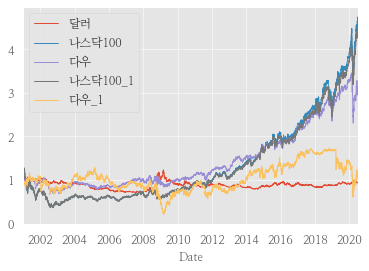

In [4]:
p = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
df = prices.copy()
df['나스닥100_1'] = p['나스닥100']*prices['달러']
df['다우_1'] = p['다우']*prices['달러']

df.dropna().rebase(1).plot();
print(df)

In [5]:
data = pd.read_csv("/Users/hosung/workspace/git/docu/data/asset_db.csv", index_col=0, parse_dates=True)
data.sample()

,kbond20y,vn30,kbond1y,uscorp15_UH,usenergy_UH,usdkrw,usbond30y_H,kbond10y,eurkrw,em_H,topx100,nasdaq100_H,cnykrw,world_UH,csi300,us500_UH,dji_UH,gold_H,kodex200x2,jpykrw,nasdaq100_UH,reit_H,kbond3y,kodex200,copper_UH,us500_H,usbond10y_UH,usdkrwx2
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-05-31,26918.589,NaN,68876.431,36604.077,4257.041,1214.300,4534.792,45231.470,1134.280,3393.912,8038.867,2274.429,146.720,4838.728,1324.236,2280.128,4559.189,2212.011,3802.943,9.783,6288.764,2366.051,57290.344,7142.686,2302.299,9224.998,5740.721,9489.317


<AxesSubplot:xlabel='Date'>

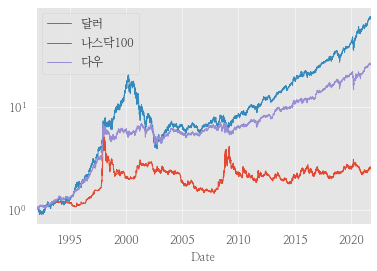

In [19]:
prices = data[['usdkrwx2', 'nasdaq100_UH', 'dji_UH']].copy()
prices.columns = ['달러','나스닥100','다우']
prices = prices.resample('D').first().fillna(method="ffill")
prices.dropna().rebase(1).plot(logy=True)
prices = prices['2001-01-02':'2020-07-02']
prices.to_csv("dollar_assets_2x.csv")

In [7]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]    

In [8]:
target_weights = pd.DataFrame()
for c in ["나스닥100", "다우"]:
    target_weights[c] = prices[c].rolling(365).apply(AMS)
target_weights = target_weights*0.5
target_weights['달러'] = 1.0 - target_weights.sum(axis=1)

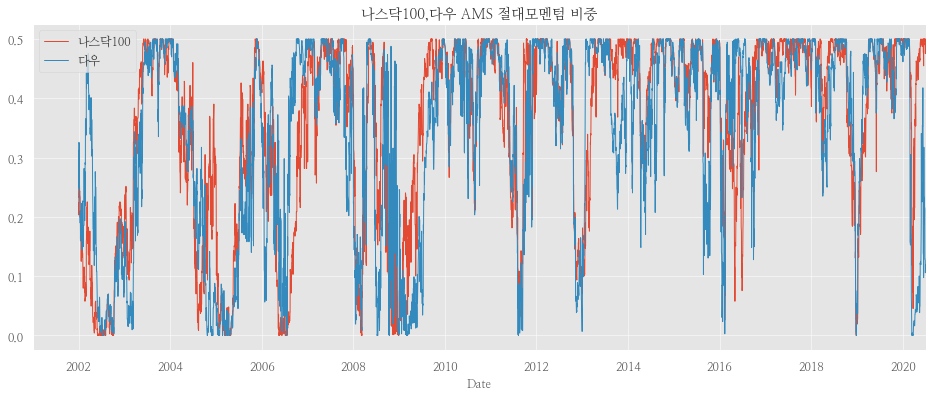

In [9]:
target_weights[['나스닥100', '다우']].plot(figsize=(16,6), title='나스닥100,다우 AMS 절대모멘텀 비중', legend=True);

In [10]:
tickers = prices.columns

In [11]:
나스닥다우동일비중 =bt.Strategy(
    "나스닥다우동일비중",
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우']),
        bt.algos.WeighEqually(),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [12]:
나스닥다우동일비중AMS = bt.Strategy(
    '나스닥다우동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우', '달러']),
        bt.algos.WeighTarget(target_weights),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [13]:
bt_나스닥다우동일비중 = bt.Backtest(나스닥다우동일비중, prices)
bt_나스닥다우동일비중AMS = bt.Backtest(나스닥다우동일비중AMS,  prices)
r = bt.run(bt_나스닥다우동일비중, bt_나스닥다우동일비중AMS)

In [14]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 나스닥다우동일비중    나스닥다우동일비중AMS
-------------------  --------------------  -----------------------
Start                2002-02-01            2002-02-01
End                  2020-07-02            2020-07-02
Risk-free rate       0.00%                 0.00%

Total Return         356.85%               202.97%
Daily Sharpe         0.43                  0.36
Daily Sortino        0.67                  0.56
CAGR                 8.60%                 6.20%
Max Drawdown         -42.81%               -32.57%
Calmar Ratio         0.20                  0.19

MTD                  1.78%                 1.44%
3m                   25.04%                9.01%
6m                   6.67%                 0.05%
YTD                  6.45%                 -0.13%
1Y                   16.64%                8.55%
3Y (ann.)            16.74%                10.56%
5Y (ann.)            15.54%                9.57%
10Y (ann.)           15.66%                10.79%
Since Incep. (ann.)  8.60%           

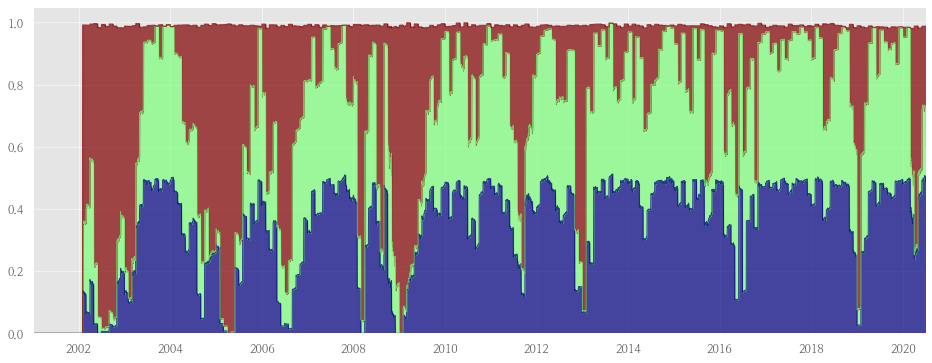

In [15]:
r.get_security_weights('나스닥다우동일비중AMS').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

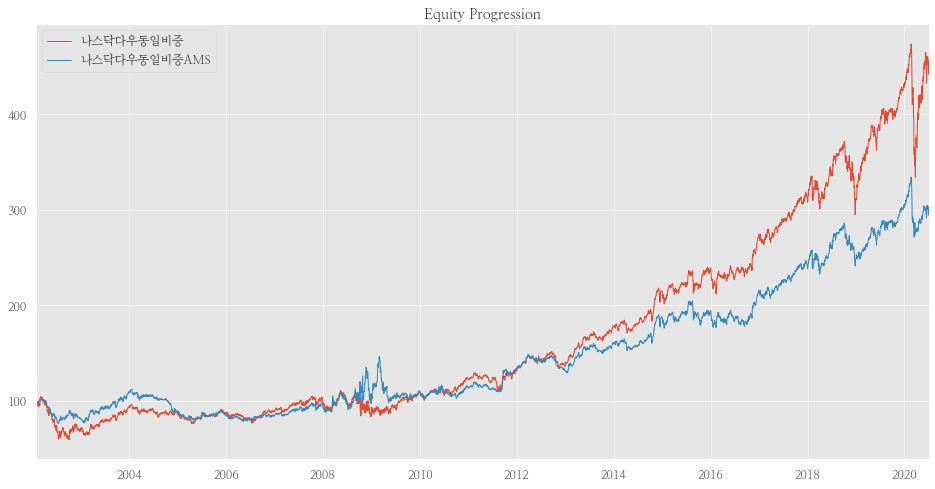

In [16]:
ax = r.plot(figsize=(16,8));
plt.legend(loc="upper left");

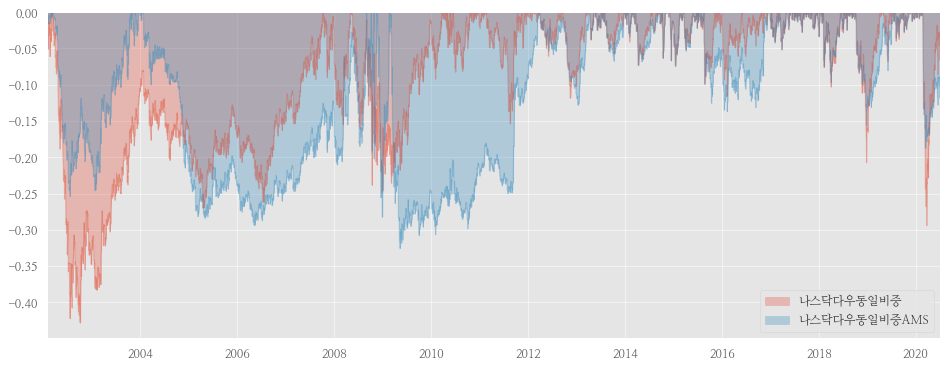

In [17]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-02  2002-02-02
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             69.0%       68.0%

Cumulative Return          202.97%     356.85%
CAGR﹪                     6.2%        8.59%

Sharpe                     0.36        0.43
Smart Sharpe               0.34        0.4
Sortino                    0.52        0.62
Smart Sortino              0.49        0.58
Sortino/√2                 0.37        0.44
Smart Sortino/√2           0.34        0.41
Omega                      1.09        1.09

Max Drawdown               -32.57%     -42.81%
Longest DD Days            1681        2037
Volatility (ann.)          14.37%      16.53%
R^2                        0.58        0.58
Calmar                     0.19        0.2
Skew                       0.68        0.75
Kurtosis                   45.98       22.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-03-03,2009-05-13,2012-03-23,1116,-32.567,-31.291
2,2004-01-27,2006-05-12,2008-09-03,1681,-29.364,-28.378
3,2008-11-25,2009-01-01,2009-02-20,87,-28.235,-28.135
4,2002-03-20,2002-07-22,2003-10-28,587,-25.401,-24.469
5,2008-10-29,2008-10-30,2008-11-20,22,-20.203,-18.421


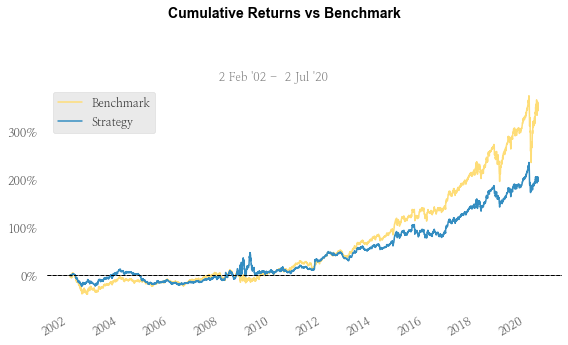

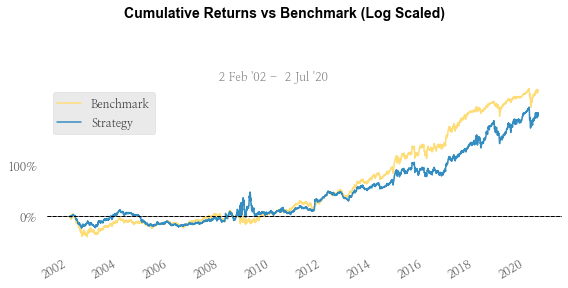

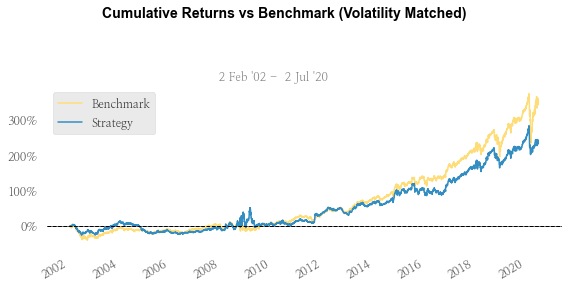

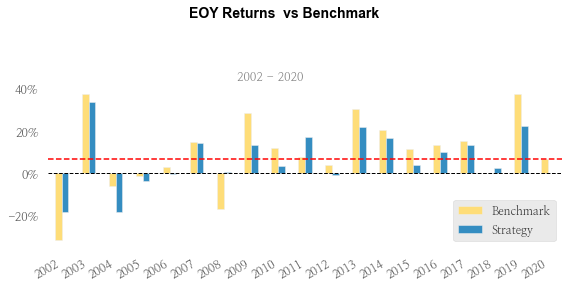

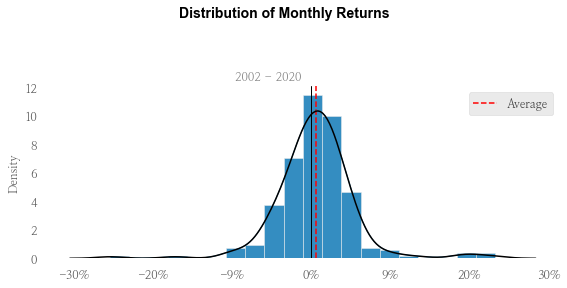

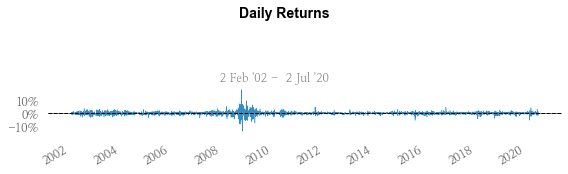

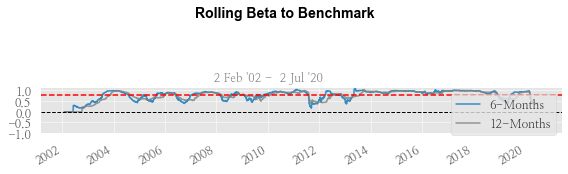

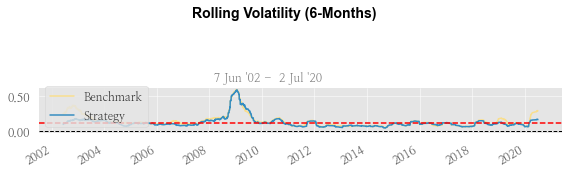

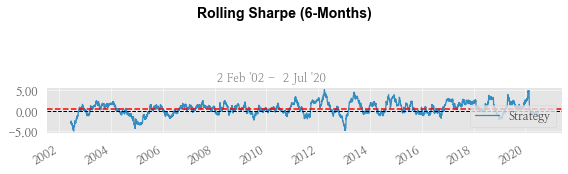

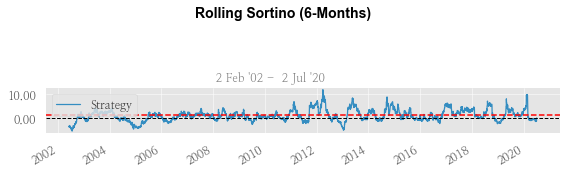

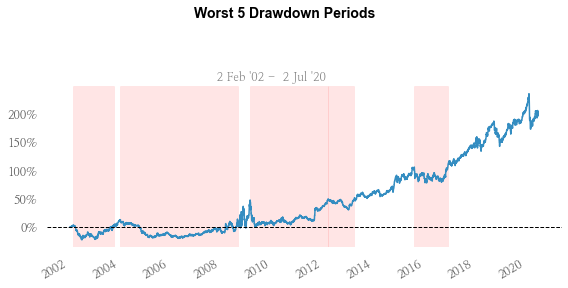

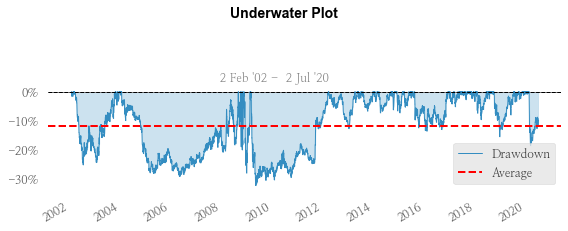

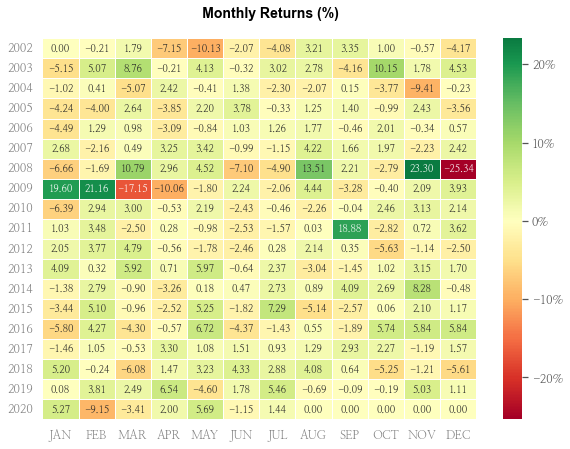

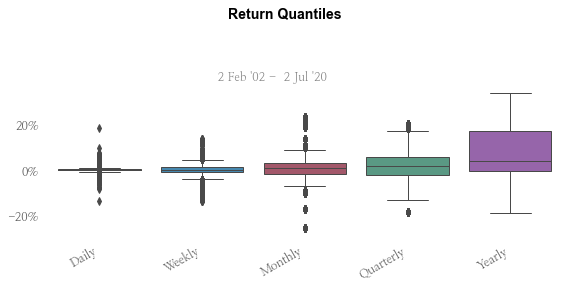

In [18]:
qs.reports.full(r['나스닥다우동일비중AMS'].prices.to_returns().dropna(), 
                r['나스닥다우동일비중'].prices.to_returns().dropna())